# Descripción del proyecto

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

### Inicialización

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer

### Cargar datos

In [2]:
try:
    df = pd.read_csv('/datasets/car_data.csv')
except:
    df = pd.read_csv(r'\datasets\car_data.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Se observa que las columnas *DateCrawled*, *DateCreated* y *LastSeen* son de tipo *object*, se pasará a *datetime*.

### Preprocesamiento de datos

In [5]:
#cambiar el dtype de tres columnas
columns_to_tim = ['DateCrawled', 'DateCreated', 'LastSeen']

for i in columns_to_tim:
    df[i] = pd.to_datetime(df[i], format = '%d/%m/%Y %H:%M')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [7]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- En los valores de la columna del *Price* y la *Power* se tiene como mínimo 0.
- La columna *RegistrationYear* tiene valores de mínimo 1000 y máximo 9999.

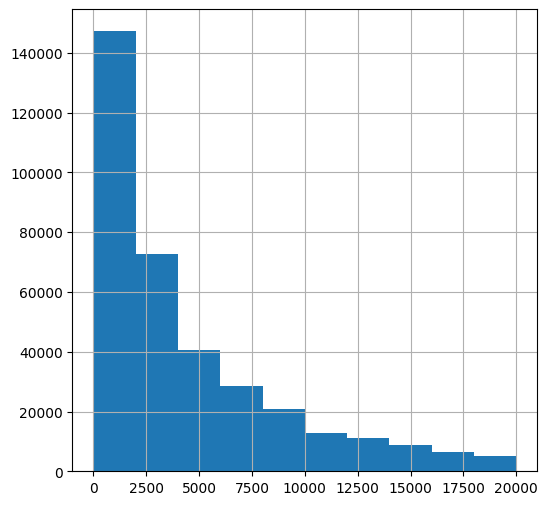

In [8]:
#graficas de algunas columnas que seran los features numéricos para el modelo
df['Price'].hist(figsize = [6,6])
plt.show()

Se observa precios desde 0, se considerará precios mayores a 0 y enteros.

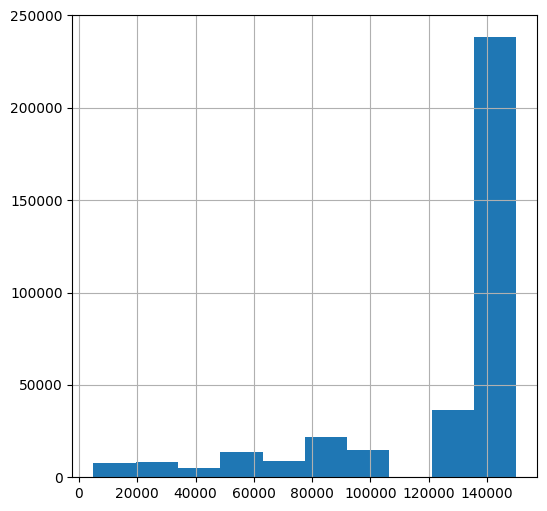

In [9]:
df['Mileage'].hist(figsize = [6,6])
plt.show()

Se observa que el pico en la columna de kilometraje se encuentra para mayores de 130000, lo cual tiene sentido al ser autos de segunda mano.

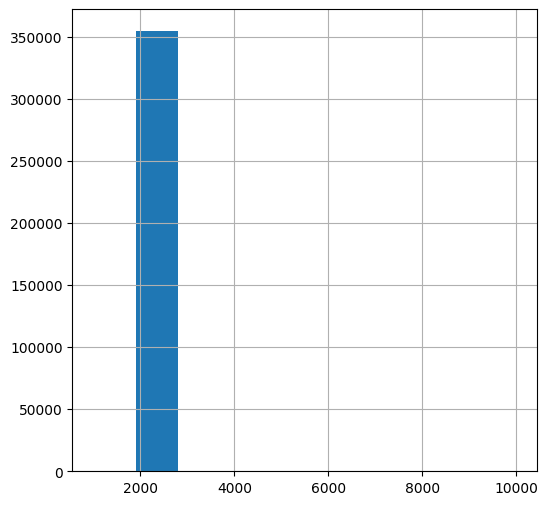

In [10]:
df['RegistrationYear'].hist(figsize = [6,6])
plt.show()

Se observa autos registrados alrededor del año 2000.

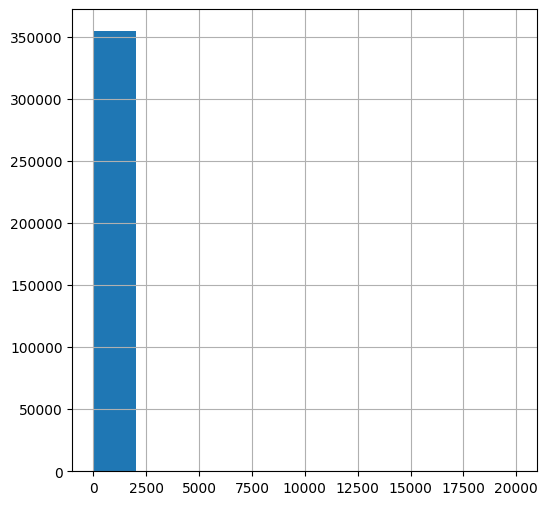

In [11]:
df['Power'].hist(figsize = [6,6])
plt.show()

Se observa potencia de autos en valor 0, se debe considerar mayores a 0.

In [12]:
df.corr()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Mileage,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


<AxesSubplot:>

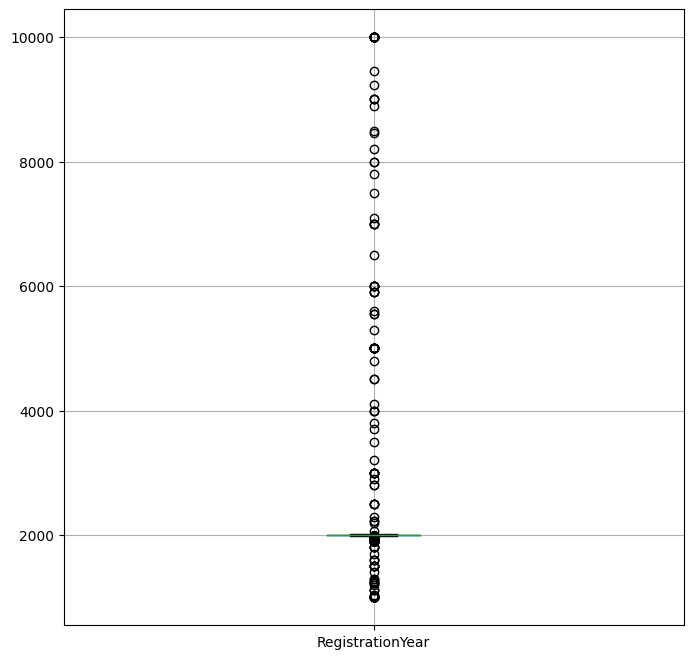

In [13]:
#Realizamos el filtro, empezamos con la columna RegistrationYear
df.boxplot(column = 'RegistrationYear', figsize = [8,8])

In [14]:
#Consideramos valores no atípicos
quantls = df.RegistrationYear.quantile([.25, .5, .75]).values
quantls

array([1999., 2003., 2008.])

In [15]:
iqr = quantls[2]-quantls[0]
lower = quantls[0] - 1.5 * iqr
upper = quantls[2] + 1.5 * iqr
upper

2021.5

In [16]:
#Verificamos valores duplicados
df.duplicated().sum()
df.drop_duplicates(inplace = True)

In [17]:
#Filtramos el DataFrame
df = df[df['Price'] > 1000]
df = df[(df['Power'] > 70) & (df['Power'] <= 3000)]
df = df[(df['RegistrationYear'] >= lower) & (df['RegistrationYear'] <= upper)]
df = df[df['RegistrationMonth'] != 0]

df = df.reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205119 entries, 0 to 205118
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        205119 non-null  datetime64[ns]
 1   Price              205119 non-null  int64         
 2   VehicleType        195684 non-null  object        
 3   RegistrationYear   205119 non-null  int64         
 4   Gearbox            202966 non-null  object        
 5   Power              205119 non-null  int64         
 6   Model              199322 non-null  object        
 7   Mileage            205119 non-null  int64         
 8   RegistrationMonth  205119 non-null  int64         
 9   FuelType           196769 non-null  object        
 10  Brand              205119 non-null  object        
 11  NotRepaired        183271 non-null  object        
 12  DateCreated        205119 non-null  datetime64[ns]
 13  NumberOfPictures   205119 non-null  int64   

Se considerará la marca del vehiculo y se omitirá el modelo del mismo, con lo que se tiene:

**Features:**

*VehicleType, RegistrationYear, Gearbox, Power, Mileage,FuelType, Brand, NotRepaired*

**Target:**

*Price*

In [18]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170041 entries, 2 to 205117
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        170041 non-null  datetime64[ns]
 1   Price              170041 non-null  int64         
 2   VehicleType        170041 non-null  object        
 3   RegistrationYear   170041 non-null  int64         
 4   Gearbox            170041 non-null  object        
 5   Power              170041 non-null  int64         
 6   Model              170041 non-null  object        
 7   Mileage            170041 non-null  int64         
 8   RegistrationMonth  170041 non-null  int64         
 9   FuelType           170041 non-null  object        
 10  Brand              170041 non-null  object        
 11  NotRepaired        170041 non-null  object        
 12  DateCreated        170041 non-null  datetime64[ns]
 13  NumberOfPictures   170041 non-null  int64   

Se tiene valores no nulos, los cuales utilizaremos para la Regresion lineal y Bosque aleatorio.

## Entrenamiento de modelos

### Escalar datos

In [19]:
#De lo expuesto anteriormente
features = df.drop(['RegistrationMonth', 'DateCreated', 'DateCrawled', 'Model', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'Price'], axis = 1)
target = df['Price']

In [20]:
#variables categoricas a ohe para XGBoost
columns_catg = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']
ohe = pd.get_dummies(data = features, columns = columns_catg, drop_first = True)

#test size ohe
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(ohe, target, test_size = 0.3, 
                                                                                             shuffle = True, random_state =12345)
ohe.head()

,RegistrationYear,Power,Mileage,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo,NotRepaired_yes
2,2001,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2004,109,150000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2004,105,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2005,140,150000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
8,2011,190,70000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#Escalaremos los datos numericos
columns_num = ['RegistrationYear', 'Power', 'Mileage']
scaler = StandardScaler()
scaler.fit(features_train_ohe[columns_num])

features_train_ohe[columns_num] = scaler.transform(features_train_ohe[columns_num])
features_valid_ohe[columns_num] = scaler.transform(features_valid_ohe[columns_num])
pd.options.mode.chained_assignment = None


/tmp/ipykernel_84/3912460042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ohe[columns_num] = scaler.transform(features_train_ohe[columns_num])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_84/3912460042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [22]:
#Para LightGBM se utiliza OrdinalEncoder para los categoricos
encoder=OrdinalEncoder()
df_encoder=pd.DataFrame(encoder.fit_transform(features), columns=features.columns)
df_encoder.head()

,VehicleType,RegistrationYear,Gearbox,Power,Mileage,FuelType,Brand,NotRepaired
0,5.0,15.0,1.0,4.0,12.0,6.0,36.0,0.0
1,1.0,18.0,1.0,38.0,12.0,6.0,25.0,0.0
2,4.0,18.0,1.0,34.0,12.0,6.0,19.0,0.0
3,7.0,19.0,1.0,69.0,12.0,2.0,36.0,1.0
4,6.0,25.0,1.0,119.0,7.0,2.0,23.0,0.0


In [23]:
#test size
features_train, features_valid, target_train, target_valid = train_test_split(df_encoder, target, test_size=0.3, 
                                                                             shuffle=True, random_state=12345)

scaler.fit(features_train[columns_num])
features_train[columns_num] = scaler.transform(features_train[columns_num])
features_valid[columns_num] = scaler.transform(features_valid[columns_num])
pd.options.mode.chained_assignment = None

In [24]:
features_train_ohe.head()

,RegistrationYear,Power,Mileage,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo,NotRepaired_yes
86477,-0.699352,-0.132127,0.639561,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
160339,-0.897799,-1.075886,0.639561,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
189771,-1.096245,-1.075886,0.639561,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
64059,0.491329,1.334069,-1.234549,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204339,-0.699352,0.525133,0.639561,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Mileage,FuelType,Brand,NotRepaired
71799,4.0,-0.699352,1.0,-0.141325,0.559031,6.0,1.0,0.0
132861,5.0,-0.897799,0.0,-1.264088,0.559031,6.0,36.0,1.0
157357,4.0,-1.096245,1.0,-1.264088,0.559031,6.0,36.0,0.0
53243,2.0,0.491329,0.0,1.602967,-0.985392,6.0,4.0,0.0
169392,7.0,-0.699352,0.0,0.640599,0.559031,6.0,20.0,0.0


A continuación se entrenaran los diferentes modelos para analizar la velocidad y calidad de los datos.

In [26]:
#funcion para el rmse
def meansqrt(y_real, y_pred):
    dif2 = (1/len(y_real))*np.sum((y_real - y_pred)**2)
    mesqrt = dif2**0.5
    return mesqrt
scorer = make_scorer(meansqrt, greater_is_better=False)


### Regresión Lineal

In [27]:
model_linear = LinearRegression()
%time model_linear.fit(features_train_ohe, target_train_ohe)


CPU times: user 598 ms, sys: 212 ms, total: 810 ms
Wall time: 777 ms


LinearRegression()

In [28]:
%time predict = model_linear.predict(features_valid_ohe)

CPU times: user 29.5 ms, sys: 62.1 ms, total: 91.5 ms
Wall time: 97.6 ms


In [29]:
rmse_lr = meansqrt(predict, target_valid_ohe)
rmse_lr

2603.8671567083497

In [30]:
#Se guarda el valor del tiempo de entrenamiento y predicción
time_fit_lr=777e-3
time_pred_lr=97.6e-3

Se encuentra un RMSE de 2603.86 para el modelo de Regresión lineal.

### Árbol de decisión

In [31]:
model_tree = DecisionTreeRegressor()
param_grid = {
    'max_depth':list(range(3,15)),
    'random_state':[12345]
}
grid_tree = GridSearchCV(estimator=model_tree, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_tree.fit(features_train_ohe, target_train_ohe)
best_param_tree=grid_tree.best_params_


In [32]:
print(best_param_tree)
print(-grid_tree.best_score_)

{'max_depth': 14, 'random_state': 12345}
1984.1245021630943


In [33]:
%time
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=14)
model_tree.fit(features_train_ohe, target_train_ohe)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [34]:
%time
prediction = model_tree.predict(features_valid_ohe)


CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.2 µs


In [35]:
rmse_tree = meansqrt(prediction, target_valid_ohe)
rmse_tree

1953.8084599827262

In [36]:
#Se guarda el valor del tiempo de entrenamiento y predicción
time_fit_tree=6.68e-6
time_pred_tree=12.2e-6

Se encuentra un RMSE de 1953.8 para el modelo de Árbol de decisión

### Bosque aleatorio

In [37]:
model_forest = RandomForestRegressor()
param_grid = {
    'n_estimators':[20],
    'max_depth':list(range(3,15)),
    'random_state':[12345]
}
grid_forest = GridSearchCV(estimator=model_forest, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_forest.fit(features_train_ohe, target_train_ohe)
best_param_forest=grid_forest.best_params_


In [38]:
print(best_param_forest)
print(-grid_forest.best_score_)

{'max_depth': 14, 'n_estimators': 20, 'random_state': 12345}
1800.489638639267


In [39]:
%time
model_ba = RandomForestRegressor(random_state=12345, n_estimators=20, max_depth=14)
model_ba.fit(features_train_ohe, target_train_ohe)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


RandomForestRegressor(max_depth=14, n_estimators=20, random_state=12345)

In [40]:
%time
prediction = model_ba.predict(features_valid_ohe)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


In [41]:
rmse_ba = meansqrt(prediction, target_valid_ohe)
rmse_ba

1783.0847823555926

In [42]:
#Se guarda el valor del tiempo de entrenamiento y predicción
time_fit_ba=7.87e-6
time_pred_ba=6.2e-6

Se tiene un RMSE de 1783.08 al utlizar *GridSearchCV* para seleccion de hiperparametros en el modelo de Bosque aleatorio.

### LightGBM

In [43]:
model_lgbm = LGBMRegressor()
param_grid = {
    'n_estimators':[20, 50],
    'seed':[12345],
    'max_depth':list(range(3, 15)),
    'objective':['regression_l2'],
    'learning_rate':[0.05, 0.4]
}

grid_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_lgbm.fit(features_train, target_train)
best_param_lgbm=grid_lgbm.best_params_

In [44]:
print(best_param_lgbm)
print(-grid_lgbm.best_score_)

{'learning_rate': 0.4, 'max_depth': 14, 'n_estimators': 50, 'objective': 'regression_l2', 'seed': 12345}
1763.081484053202


In [45]:
%time
model_lgbm = LGBMRegressor(n_estimators=50, seed=12345, max_depth=14, objective='regression_l2', learning_rate=0.4)
model_lgbm.fit(features_train, target_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


LGBMRegressor(learning_rate=0.4, max_depth=14, n_estimators=50,
              objective='regression_l2', seed=12345)

In [46]:
%time
prediction = model_lgbm.predict(features_valid)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [47]:
rmse_lgbm = meansqrt(prediction, target_valid)
rmse_lgbm

1761.5704551974222

In [48]:
#Se guarda el valor del tiempo de entrenamiento y predicción
time_fit_lgbm=6.91e-6
time_pred_lgbm=7.15e-6

Se tiene un RMSE de 1761.57 al utlizar *GridSearchCV* para seleccion de hiperparametros en el modelo de LightGBM.

### CatBoost

In [49]:
model_cat = CatBoostRegressor()
param_grid = {
    'n_estimators':[20, 50],
    'random_seed':[12345],
    'max_depth':list(range(3, 15)),
    'loss_function':['RMSE'],
    'learning_rate':[0.05, 0.4],
    'l2_leaf_reg':[0.5]
}

grid_cat = GridSearchCV(estimator=model_cat, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_cat.fit(features_train, target_train)
best_param_cat=grid_cat.best_params_


0:	learn: 4629.6899300	total: 61.9ms	remaining: 1.18s
1:	learn: 4503.7444765	total: 74.2ms	remaining: 668ms
2:	learn: 4385.9850042	total: 87.9ms	remaining: 498ms
3:	learn: 4270.8182493	total: 101ms	remaining: 403ms
4:	learn: 4167.9945445	total: 115ms	remaining: 345ms
5:	learn: 4072.2158295	total: 128ms	remaining: 299ms
6:	learn: 3979.8488507	total: 141ms	remaining: 263ms
7:	learn: 3891.5114031	total: 154ms	remaining: 230ms
8:	learn: 3809.4945115	total: 167ms	remaining: 204ms
9:	learn: 3729.5250161	total: 180ms	remaining: 180ms
10:	learn: 3654.7559291	total: 194ms	remaining: 159ms
11:	learn: 3584.6049311	total: 207ms	remaining: 138ms
12:	learn: 3519.7055142	total: 219ms	remaining: 118ms
13:	learn: 3456.8060191	total: 233ms	remaining: 99.7ms
14:	learn: 3396.6514666	total: 246ms	remaining: 81.9ms
15:	learn: 3341.2056469	total: 259ms	remaining: 64.7ms
16:	learn: 3288.7490084	total: 271ms	remaining: 47.8ms
17:	learn: 3240.8613922	total: 284ms	remaining: 31.6ms
18:	learn: 3193.6598741	total:

16:	learn: 3291.8880431	total: 224ms	remaining: 436ms
17:	learn: 3243.6669816	total: 237ms	remaining: 422ms
18:	learn: 3197.0193550	total: 250ms	remaining: 408ms
19:	learn: 3154.1649114	total: 264ms	remaining: 395ms
20:	learn: 3114.3360568	total: 277ms	remaining: 383ms
21:	learn: 3075.9185873	total: 289ms	remaining: 368ms
22:	learn: 3038.3717104	total: 301ms	remaining: 354ms
23:	learn: 3004.3092741	total: 313ms	remaining: 339ms
24:	learn: 2970.3606019	total: 325ms	remaining: 325ms
25:	learn: 2938.2334440	total: 339ms	remaining: 313ms
26:	learn: 2909.4848064	total: 351ms	remaining: 299ms
27:	learn: 2882.4591497	total: 364ms	remaining: 286ms
28:	learn: 2856.0100438	total: 377ms	remaining: 273ms
29:	learn: 2830.6005898	total: 391ms	remaining: 260ms
30:	learn: 2808.0202679	total: 403ms	remaining: 247ms
31:	learn: 2786.8721465	total: 415ms	remaining: 234ms
32:	learn: 2767.0914466	total: 429ms	remaining: 221ms
33:	learn: 2747.5555539	total: 442ms	remaining: 208ms
34:	learn: 2728.3799388	tota

19:	learn: 3149.0755774	total: 255ms	remaining: 383ms
20:	learn: 3110.2963415	total: 268ms	remaining: 371ms
21:	learn: 3072.5835967	total: 280ms	remaining: 357ms
22:	learn: 3035.6486965	total: 293ms	remaining: 344ms
23:	learn: 3001.0732574	total: 305ms	remaining: 331ms
24:	learn: 2968.2131313	total: 318ms	remaining: 318ms
25:	learn: 2936.2687258	total: 330ms	remaining: 305ms
26:	learn: 2907.5514678	total: 346ms	remaining: 295ms
27:	learn: 2879.9763555	total: 359ms	remaining: 282ms
28:	learn: 2852.9290282	total: 372ms	remaining: 269ms
29:	learn: 2827.1682004	total: 384ms	remaining: 256ms
30:	learn: 2804.8145873	total: 396ms	remaining: 243ms
31:	learn: 2782.6532069	total: 408ms	remaining: 230ms
32:	learn: 2762.1923041	total: 420ms	remaining: 217ms
33:	learn: 2742.8468549	total: 433ms	remaining: 204ms
34:	learn: 2723.3720953	total: 445ms	remaining: 191ms
35:	learn: 2705.2442735	total: 457ms	remaining: 178ms
36:	learn: 2688.2426668	total: 470ms	remaining: 165ms
37:	learn: 2672.0890934	tota

30:	learn: 2695.5010117	total: 433ms	remaining: 265ms
31:	learn: 2673.9512670	total: 446ms	remaining: 251ms
32:	learn: 2652.9787664	total: 463ms	remaining: 239ms
33:	learn: 2632.9288261	total: 476ms	remaining: 224ms
34:	learn: 2612.8531872	total: 489ms	remaining: 210ms
35:	learn: 2595.1629605	total: 502ms	remaining: 195ms
36:	learn: 2577.6184624	total: 516ms	remaining: 181ms
37:	learn: 2561.2373976	total: 530ms	remaining: 167ms
38:	learn: 2546.2511797	total: 542ms	remaining: 153ms
39:	learn: 2531.2967978	total: 556ms	remaining: 139ms
40:	learn: 2518.0518106	total: 569ms	remaining: 125ms
41:	learn: 2504.6128258	total: 582ms	remaining: 111ms
42:	learn: 2491.4072610	total: 596ms	remaining: 97.1ms
43:	learn: 2479.0602892	total: 610ms	remaining: 83.2ms
44:	learn: 2467.6562067	total: 623ms	remaining: 69.2ms
45:	learn: 2456.4851945	total: 638ms	remaining: 55.4ms
46:	learn: 2445.3924803	total: 654ms	remaining: 41.8ms
47:	learn: 2435.1591965	total: 667ms	remaining: 27.8ms
48:	learn: 2425.551890

45:	learn: 2445.7258670	total: 628ms	remaining: 54.6ms
46:	learn: 2434.0602705	total: 641ms	remaining: 40.9ms
47:	learn: 2422.5214149	total: 658ms	remaining: 27.4ms
48:	learn: 2412.3649833	total: 671ms	remaining: 13.7ms
49:	learn: 2401.9740364	total: 684ms	remaining: 0us
0:	learn: 4618.1371774	total: 14.1ms	remaining: 692ms
1:	learn: 4482.5452983	total: 27.6ms	remaining: 662ms
2:	learn: 4355.3489242	total: 40.7ms	remaining: 637ms
3:	learn: 4234.0997171	total: 54.5ms	remaining: 626ms
4:	learn: 4119.4144417	total: 68.6ms	remaining: 617ms
5:	learn: 4012.6396419	total: 81.8ms	remaining: 600ms
6:	learn: 3911.0659841	total: 95.8ms	remaining: 588ms
7:	learn: 3817.8083823	total: 110ms	remaining: 578ms
8:	learn: 3728.3606520	total: 124ms	remaining: 564ms
9:	learn: 3645.7948217	total: 137ms	remaining: 549ms
10:	learn: 3568.2768246	total: 151ms	remaining: 536ms
11:	learn: 3493.0734221	total: 165ms	remaining: 524ms
12:	learn: 3420.7557375	total: 180ms	remaining: 511ms
13:	learn: 3356.7820166	total

0:	learn: 4615.7557415	total: 14.7ms	remaining: 720ms
1:	learn: 4471.5468012	total: 29.2ms	remaining: 701ms
2:	learn: 4335.8386579	total: 44.9ms	remaining: 704ms
3:	learn: 4209.1843745	total: 59.8ms	remaining: 687ms
4:	learn: 4089.6625868	total: 74.7ms	remaining: 672ms
5:	learn: 3974.5406501	total: 90.1ms	remaining: 661ms
6:	learn: 3871.1915411	total: 105ms	remaining: 647ms
7:	learn: 3770.9717109	total: 120ms	remaining: 632ms
8:	learn: 3675.8016250	total: 135ms	remaining: 616ms
9:	learn: 3588.4733047	total: 150ms	remaining: 599ms
10:	learn: 3508.7138540	total: 165ms	remaining: 584ms
11:	learn: 3430.3068710	total: 180ms	remaining: 569ms
12:	learn: 3357.2575429	total: 194ms	remaining: 552ms
13:	learn: 3290.8084801	total: 209ms	remaining: 538ms
14:	learn: 3228.5514054	total: 225ms	remaining: 525ms
15:	learn: 3168.8993067	total: 240ms	remaining: 510ms
16:	learn: 3111.8170106	total: 255ms	remaining: 494ms
17:	learn: 3059.0240268	total: 269ms	remaining: 478ms
18:	learn: 3009.9619926	total: 2

13:	learn: 3280.7371807	total: 216ms	remaining: 555ms
14:	learn: 3216.9611067	total: 237ms	remaining: 554ms
15:	learn: 3159.0504405	total: 254ms	remaining: 539ms
16:	learn: 3103.2806510	total: 268ms	remaining: 521ms
17:	learn: 3049.9417038	total: 283ms	remaining: 503ms
18:	learn: 3000.3524865	total: 298ms	remaining: 485ms
19:	learn: 2955.3507937	total: 312ms	remaining: 468ms
20:	learn: 2912.7715125	total: 327ms	remaining: 451ms
21:	learn: 2871.5859680	total: 351ms	remaining: 446ms
22:	learn: 2831.8724498	total: 365ms	remaining: 429ms
23:	learn: 2796.5302515	total: 380ms	remaining: 412ms
24:	learn: 2763.1846711	total: 396ms	remaining: 396ms
25:	learn: 2729.7071749	total: 411ms	remaining: 379ms
26:	learn: 2698.0351893	total: 432ms	remaining: 368ms
27:	learn: 2669.6651866	total: 451ms	remaining: 355ms
28:	learn: 2642.8716452	total: 467ms	remaining: 338ms
29:	learn: 2617.5948660	total: 482ms	remaining: 321ms
30:	learn: 2594.6707595	total: 496ms	remaining: 304ms
31:	learn: 2572.5216724	tota

12:	learn: 3303.3205450	total: 222ms	remaining: 120ms
13:	learn: 3232.9885586	total: 239ms	remaining: 103ms
14:	learn: 3168.0391720	total: 257ms	remaining: 85.7ms
15:	learn: 3107.8640679	total: 274ms	remaining: 68.5ms
16:	learn: 3049.7737732	total: 291ms	remaining: 51.3ms
17:	learn: 2995.2168982	total: 308ms	remaining: 34.2ms
18:	learn: 2945.6242617	total: 324ms	remaining: 17.1ms
19:	learn: 2899.7669650	total: 340ms	remaining: 0us
0:	learn: 4605.3966032	total: 17ms	remaining: 323ms
1:	learn: 4456.6673813	total: 34.1ms	remaining: 307ms
2:	learn: 4314.4212878	total: 51.1ms	remaining: 290ms
3:	learn: 4182.1202344	total: 68.4ms	remaining: 274ms
4:	learn: 4058.8511183	total: 84.5ms	remaining: 253ms
5:	learn: 3941.8412806	total: 102ms	remaining: 238ms
6:	learn: 3831.9945048	total: 118ms	remaining: 220ms
7:	learn: 3728.3366684	total: 137ms	remaining: 205ms
8:	learn: 3632.5820056	total: 153ms	remaining: 187ms
9:	learn: 3543.6687123	total: 170ms	remaining: 170ms
10:	learn: 3457.6270250	total: 1

36:	learn: 2424.8047992	total: 631ms	remaining: 222ms
37:	learn: 2406.8580928	total: 653ms	remaining: 206ms
38:	learn: 2391.4695398	total: 669ms	remaining: 189ms
39:	learn: 2378.0681232	total: 685ms	remaining: 171ms
40:	learn: 2365.2941134	total: 701ms	remaining: 154ms
41:	learn: 2350.3144781	total: 721ms	remaining: 137ms
42:	learn: 2339.2867649	total: 736ms	remaining: 120ms
43:	learn: 2326.1557595	total: 752ms	remaining: 103ms
44:	learn: 2313.5898405	total: 769ms	remaining: 85.4ms
45:	learn: 2303.4067838	total: 785ms	remaining: 68.2ms
46:	learn: 2294.2062544	total: 800ms	remaining: 51.1ms
47:	learn: 2285.6896322	total: 815ms	remaining: 34ms
48:	learn: 2276.8912707	total: 831ms	remaining: 17ms
49:	learn: 2267.3174324	total: 847ms	remaining: 0us
0:	learn: 4603.4143571	total: 17.8ms	remaining: 870ms
1:	learn: 4454.8378075	total: 34.4ms	remaining: 827ms
2:	learn: 4313.6054612	total: 51.5ms	remaining: 807ms
3:	learn: 4181.9122240	total: 68.1ms	remaining: 784ms
4:	learn: 4056.4312735	total:

0:	learn: 4601.0965447	total: 18.1ms	remaining: 344ms
1:	learn: 4447.8273484	total: 38.1ms	remaining: 343ms
2:	learn: 4302.3086926	total: 56.4ms	remaining: 320ms
3:	learn: 4169.7059616	total: 75ms	remaining: 300ms
4:	learn: 4040.6986084	total: 95.8ms	remaining: 288ms
5:	learn: 3923.5723950	total: 115ms	remaining: 268ms
6:	learn: 3811.4944931	total: 135ms	remaining: 250ms
7:	learn: 3707.7929398	total: 154ms	remaining: 232ms
8:	learn: 3607.8407807	total: 173ms	remaining: 211ms
9:	learn: 3515.8633284	total: 192ms	remaining: 192ms
10:	learn: 3428.5328418	total: 210ms	remaining: 172ms
11:	learn: 3345.9832664	total: 228ms	remaining: 152ms
12:	learn: 3269.5278904	total: 246ms	remaining: 133ms
13:	learn: 3197.4459994	total: 265ms	remaining: 114ms
14:	learn: 3131.7056010	total: 290ms	remaining: 96.7ms
15:	learn: 3068.6455265	total: 309ms	remaining: 77.2ms
16:	learn: 3008.2575192	total: 326ms	remaining: 57.6ms
17:	learn: 2952.1779319	total: 346ms	remaining: 38.5ms
18:	learn: 2899.6845998	total: 

44:	learn: 2245.2472990	total: 858ms	remaining: 95.3ms
45:	learn: 2232.4445374	total: 882ms	remaining: 76.7ms
46:	learn: 2222.2428187	total: 898ms	remaining: 57.3ms
47:	learn: 2209.7492194	total: 916ms	remaining: 38.2ms
48:	learn: 2198.7059716	total: 935ms	remaining: 19.1ms
49:	learn: 2189.6879180	total: 954ms	remaining: 0us
0:	learn: 4601.0965447	total: 17.8ms	remaining: 875ms
1:	learn: 4447.8273484	total: 39ms	remaining: 937ms
2:	learn: 4302.3086926	total: 59.8ms	remaining: 937ms
3:	learn: 4169.7059616	total: 78.8ms	remaining: 906ms
4:	learn: 4040.6986084	total: 97.6ms	remaining: 879ms
5:	learn: 3923.5723950	total: 116ms	remaining: 853ms
6:	learn: 3811.4944931	total: 136ms	remaining: 836ms
7:	learn: 3707.7929398	total: 155ms	remaining: 815ms
8:	learn: 3607.8407807	total: 174ms	remaining: 793ms
9:	learn: 3515.8633284	total: 192ms	remaining: 769ms
10:	learn: 3428.5328418	total: 210ms	remaining: 745ms
11:	learn: 3345.9832664	total: 229ms	remaining: 725ms
12:	learn: 3269.5278904	total: 2

0:	learn: 4603.5157598	total: 23ms	remaining: 438ms
1:	learn: 4446.7645869	total: 45.2ms	remaining: 407ms
2:	learn: 4298.3053817	total: 69.4ms	remaining: 393ms
3:	learn: 4158.8981084	total: 91.7ms	remaining: 367ms
4:	learn: 4027.9901832	total: 116ms	remaining: 347ms
5:	learn: 3904.8968698	total: 138ms	remaining: 322ms
6:	learn: 3790.2208188	total: 159ms	remaining: 296ms
7:	learn: 3683.5154133	total: 179ms	remaining: 269ms
8:	learn: 3582.5364326	total: 201ms	remaining: 245ms
9:	learn: 3486.9972684	total: 223ms	remaining: 223ms
10:	learn: 3396.5945707	total: 245ms	remaining: 200ms
11:	learn: 3312.3945744	total: 265ms	remaining: 177ms
12:	learn: 3232.4469957	total: 288ms	remaining: 155ms
13:	learn: 3158.4041003	total: 312ms	remaining: 134ms
14:	learn: 3090.1289434	total: 334ms	remaining: 111ms
15:	learn: 3026.3142619	total: 355ms	remaining: 88.8ms
16:	learn: 2964.9288522	total: 377ms	remaining: 66.5ms
17:	learn: 2910.0063147	total: 398ms	remaining: 44.3ms
18:	learn: 2858.1823795	total: 42

12:	learn: 3236.1711210	total: 286ms	remaining: 815ms
13:	learn: 3161.2634050	total: 309ms	remaining: 795ms
14:	learn: 3091.8897391	total: 334ms	remaining: 779ms
15:	learn: 3027.6687300	total: 355ms	remaining: 755ms
16:	learn: 2966.9587196	total: 377ms	remaining: 733ms
17:	learn: 2910.7525549	total: 398ms	remaining: 708ms
18:	learn: 2858.2741026	total: 421ms	remaining: 686ms
19:	learn: 2808.7676505	total: 443ms	remaining: 664ms
20:	learn: 2760.2030969	total: 465ms	remaining: 643ms
21:	learn: 2716.2777084	total: 489ms	remaining: 622ms
22:	learn: 2676.2962301	total: 510ms	remaining: 599ms
23:	learn: 2636.0481260	total: 534ms	remaining: 579ms
24:	learn: 2598.8917326	total: 558ms	remaining: 558ms
25:	learn: 2564.6439706	total: 580ms	remaining: 535ms
26:	learn: 2532.9849083	total: 600ms	remaining: 511ms
27:	learn: 2502.4584195	total: 622ms	remaining: 489ms
28:	learn: 2474.8586795	total: 642ms	remaining: 465ms
29:	learn: 2449.6267520	total: 664ms	remaining: 443ms
30:	learn: 2423.9434678	tota

20:	learn: 2753.7753557	total: 482ms	remaining: 665ms
21:	learn: 2710.1438941	total: 506ms	remaining: 644ms
22:	learn: 2670.8309174	total: 528ms	remaining: 619ms
23:	learn: 2632.8719686	total: 550ms	remaining: 596ms
24:	learn: 2595.7193030	total: 577ms	remaining: 577ms
25:	learn: 2561.2321324	total: 600ms	remaining: 554ms
26:	learn: 2528.2699394	total: 623ms	remaining: 530ms
27:	learn: 2499.2294825	total: 646ms	remaining: 508ms
28:	learn: 2471.7088948	total: 670ms	remaining: 485ms
29:	learn: 2446.4722838	total: 694ms	remaining: 462ms
30:	learn: 2419.7561162	total: 716ms	remaining: 439ms
31:	learn: 2396.3472491	total: 738ms	remaining: 415ms
32:	learn: 2374.5745787	total: 759ms	remaining: 391ms
33:	learn: 2354.8011978	total: 785ms	remaining: 370ms
34:	learn: 2333.9529931	total: 808ms	remaining: 346ms
35:	learn: 2314.7554489	total: 832ms	remaining: 324ms
36:	learn: 2297.9685673	total: 852ms	remaining: 299ms
37:	learn: 2277.6104517	total: 874ms	remaining: 276ms
38:	learn: 2263.0503365	tota

27:	learn: 2456.9751599	total: 737ms	remaining: 579ms
28:	learn: 2429.7777294	total: 761ms	remaining: 551ms
29:	learn: 2401.5006757	total: 790ms	remaining: 527ms
30:	learn: 2375.9732261	total: 816ms	remaining: 500ms
31:	learn: 2348.5858210	total: 843ms	remaining: 474ms
32:	learn: 2326.8433193	total: 865ms	remaining: 446ms
33:	learn: 2305.7285601	total: 891ms	remaining: 420ms
34:	learn: 2285.2440981	total: 919ms	remaining: 394ms
35:	learn: 2265.2299628	total: 942ms	remaining: 366ms
36:	learn: 2247.6692695	total: 968ms	remaining: 340ms
37:	learn: 2231.3943287	total: 997ms	remaining: 315ms
38:	learn: 2215.0094681	total: 1.02s	remaining: 288ms
39:	learn: 2199.4650196	total: 1.05s	remaining: 262ms
40:	learn: 2186.6144924	total: 1.07s	remaining: 236ms
41:	learn: 2170.9114293	total: 1.1s	remaining: 209ms
42:	learn: 2160.2821442	total: 1.13s	remaining: 183ms
43:	learn: 2148.0599411	total: 1.15s	remaining: 157ms
44:	learn: 2137.8915949	total: 1.17s	remaining: 130ms
45:	learn: 2126.8010549	total

35:	learn: 2262.9245276	total: 895ms	remaining: 348ms
36:	learn: 2246.0843141	total: 920ms	remaining: 323ms
37:	learn: 2230.9963833	total: 950ms	remaining: 300ms
38:	learn: 2212.0654694	total: 973ms	remaining: 274ms
39:	learn: 2197.8932556	total: 996ms	remaining: 249ms
40:	learn: 2180.8750984	total: 1.02s	remaining: 224ms
41:	learn: 2165.8193619	total: 1.04s	remaining: 199ms
42:	learn: 2154.1842305	total: 1.07s	remaining: 174ms
43:	learn: 2141.4051693	total: 1.09s	remaining: 149ms
44:	learn: 2131.1017637	total: 1.12s	remaining: 124ms
45:	learn: 2121.7538990	total: 1.14s	remaining: 99.1ms
46:	learn: 2110.2053463	total: 1.17s	remaining: 74.6ms
47:	learn: 2097.5273005	total: 1.19s	remaining: 49.7ms
48:	learn: 2087.6254286	total: 1.22s	remaining: 24.9ms
49:	learn: 2076.2655808	total: 1.24s	remaining: 0us
0:	learn: 4593.6890985	total: 26.7ms	remaining: 1.31s
1:	learn: 4435.0723326	total: 51.6ms	remaining: 1.24s
2:	learn: 4284.0352641	total: 77.1ms	remaining: 1.21s
3:	learn: 4143.6234222	tot

10:	learn: 3344.3523601	total: 512ms	remaining: 419ms
11:	learn: 3254.7620078	total: 562ms	remaining: 375ms
12:	learn: 3174.0697585	total: 611ms	remaining: 329ms
13:	learn: 3099.3606054	total: 658ms	remaining: 282ms
14:	learn: 3028.8585279	total: 707ms	remaining: 236ms
15:	learn: 2960.0930819	total: 758ms	remaining: 190ms
16:	learn: 2893.7029304	total: 806ms	remaining: 142ms
17:	learn: 2833.9755689	total: 852ms	remaining: 94.7ms
18:	learn: 2775.9335530	total: 900ms	remaining: 47.4ms
19:	learn: 2722.5632068	total: 948ms	remaining: 0us
0:	learn: 4597.9504128	total: 48.6ms	remaining: 2.38s
1:	learn: 4434.6478438	total: 93.6ms	remaining: 2.25s
2:	learn: 4282.5933686	total: 142ms	remaining: 2.22s
3:	learn: 4139.4484390	total: 190ms	remaining: 2.18s
4:	learn: 4005.8978793	total: 232ms	remaining: 2.09s
5:	learn: 3877.5811068	total: 279ms	remaining: 2.05s
6:	learn: 3758.8778806	total: 329ms	remaining: 2.02s
7:	learn: 3646.1612451	total: 376ms	remaining: 1.97s
8:	learn: 3538.5331376	total: 422m

45:	learn: 2085.2390425	total: 2.17s	remaining: 188ms
46:	learn: 2074.4114958	total: 2.21s	remaining: 141ms
47:	learn: 2064.8623084	total: 2.26s	remaining: 94.3ms
48:	learn: 2056.3710525	total: 2.31s	remaining: 47.1ms
49:	learn: 2048.1135457	total: 2.36s	remaining: 0us
0:	learn: 4589.5967362	total: 45.8ms	remaining: 2.25s
1:	learn: 4426.7581167	total: 94.5ms	remaining: 2.27s
2:	learn: 4274.8554615	total: 142ms	remaining: 2.22s
3:	learn: 4132.8696413	total: 190ms	remaining: 2.18s
4:	learn: 3999.5666099	total: 237ms	remaining: 2.13s
5:	learn: 3872.0212701	total: 284ms	remaining: 2.08s
6:	learn: 3751.1197215	total: 333ms	remaining: 2.05s
7:	learn: 3638.2143340	total: 379ms	remaining: 1.99s
8:	learn: 3531.8007984	total: 427ms	remaining: 1.95s
9:	learn: 3434.3486765	total: 469ms	remaining: 1.88s
10:	learn: 3340.6522740	total: 523ms	remaining: 1.85s
11:	learn: 3252.9376035	total: 571ms	remaining: 1.81s
12:	learn: 3172.7750341	total: 618ms	remaining: 1.76s
13:	learn: 3097.2546070	total: 665ms

8:	learn: 3513.6488411	total: 525ms	remaining: 641ms
9:	learn: 3414.7189714	total: 581ms	remaining: 581ms
10:	learn: 3321.5031954	total: 637ms	remaining: 521ms
11:	learn: 3231.7895613	total: 696ms	remaining: 464ms
12:	learn: 3148.2443782	total: 755ms	remaining: 406ms
13:	learn: 3070.1083332	total: 818ms	remaining: 350ms
14:	learn: 2998.1151408	total: 874ms	remaining: 291ms
15:	learn: 2927.9211972	total: 932ms	remaining: 233ms
16:	learn: 2862.7603072	total: 986ms	remaining: 174ms
17:	learn: 2802.4651858	total: 1.04s	remaining: 116ms
18:	learn: 2747.3920653	total: 1.1s	remaining: 58.1ms
19:	learn: 2695.5200271	total: 1.16s	remaining: 0us
0:	learn: 4586.2989537	total: 60.1ms	remaining: 1.14s
1:	learn: 4421.1512572	total: 119ms	remaining: 1.07s
2:	learn: 4267.7305747	total: 175ms	remaining: 990ms
3:	learn: 4123.4969844	total: 229ms	remaining: 916ms
4:	learn: 3985.0659003	total: 285ms	remaining: 855ms
5:	learn: 3856.2867660	total: 344ms	remaining: 803ms
6:	learn: 3734.6689755	total: 404ms	r

4:	learn: 3986.3076405	total: 290ms	remaining: 2.61s
5:	learn: 3858.8069398	total: 348ms	remaining: 2.55s
6:	learn: 3738.2339864	total: 407ms	remaining: 2.5s
7:	learn: 3623.4583297	total: 465ms	remaining: 2.44s
8:	learn: 3513.6488411	total: 523ms	remaining: 2.38s
9:	learn: 3414.7189714	total: 583ms	remaining: 2.33s
10:	learn: 3321.5031954	total: 641ms	remaining: 2.27s
11:	learn: 3231.7895613	total: 700ms	remaining: 2.22s
12:	learn: 3148.2443782	total: 757ms	remaining: 2.15s
13:	learn: 3070.1083332	total: 814ms	remaining: 2.09s
14:	learn: 2998.1151408	total: 875ms	remaining: 2.04s
15:	learn: 2927.9211972	total: 933ms	remaining: 1.98s
16:	learn: 2862.7603072	total: 992ms	remaining: 1.92s
17:	learn: 2802.4651858	total: 1.05s	remaining: 1.87s
18:	learn: 2747.3920653	total: 1.11s	remaining: 1.81s
19:	learn: 2695.5200271	total: 1.17s	remaining: 1.75s
20:	learn: 2645.0997473	total: 1.23s	remaining: 1.69s
21:	learn: 2599.0253231	total: 1.29s	remaining: 1.64s
22:	learn: 2555.1755338	total: 1.35

9:	learn: 3392.5077648	total: 764ms	remaining: 764ms
10:	learn: 3296.7102381	total: 846ms	remaining: 692ms
11:	learn: 3206.9469902	total: 922ms	remaining: 615ms
12:	learn: 3120.0881531	total: 1s	remaining: 540ms
13:	learn: 3040.0638511	total: 1.08s	remaining: 463ms
14:	learn: 2965.6698567	total: 1.16s	remaining: 385ms
15:	learn: 2894.3264869	total: 1.23s	remaining: 307ms
16:	learn: 2829.7571519	total: 1.31s	remaining: 231ms
17:	learn: 2768.9193561	total: 1.38s	remaining: 154ms
18:	learn: 2711.8538030	total: 1.46s	remaining: 76.7ms
19:	learn: 2657.0369128	total: 1.53s	remaining: 0us
0:	learn: 4593.7122769	total: 77.1ms	remaining: 1.47s
1:	learn: 4428.5260855	total: 151ms	remaining: 1.36s
2:	learn: 4270.2064320	total: 225ms	remaining: 1.28s
3:	learn: 4120.2756949	total: 301ms	remaining: 1.2s
4:	learn: 3981.3918317	total: 377ms	remaining: 1.13s
5:	learn: 3851.1708049	total: 454ms	remaining: 1.06s
6:	learn: 3727.4003198	total: 529ms	remaining: 983ms
7:	learn: 3611.8019363	total: 608ms	rema

15:	learn: 2900.0670802	total: 1.23s	remaining: 2.62s
16:	learn: 2835.5458480	total: 1.31s	remaining: 2.54s
17:	learn: 2773.8141374	total: 1.39s	remaining: 2.46s
18:	learn: 2717.7050366	total: 1.47s	remaining: 2.39s
19:	learn: 2662.7100309	total: 1.54s	remaining: 2.31s
20:	learn: 2612.0976374	total: 1.61s	remaining: 2.23s
21:	learn: 2565.1994551	total: 1.69s	remaining: 2.15s
22:	learn: 2521.1182025	total: 1.77s	remaining: 2.07s
23:	learn: 2477.2228046	total: 1.84s	remaining: 2s
24:	learn: 2439.4216417	total: 1.92s	remaining: 1.92s
25:	learn: 2401.1570626	total: 1.99s	remaining: 1.84s
26:	learn: 2364.6172091	total: 2.07s	remaining: 1.76s
27:	learn: 2334.3417310	total: 2.15s	remaining: 1.69s
28:	learn: 2302.7631188	total: 2.22s	remaining: 1.6s
29:	learn: 2273.6074196	total: 2.29s	remaining: 1.53s
30:	learn: 2243.8370856	total: 2.37s	remaining: 1.45s
31:	learn: 2219.2804769	total: 2.44s	remaining: 1.37s
32:	learn: 2196.9827076	total: 2.52s	remaining: 1.3s
33:	learn: 2175.3120581	total: 2.

18:	learn: 2717.5945448	total: 1.43s	remaining: 2.34s
19:	learn: 2662.7227458	total: 1.51s	remaining: 2.27s
20:	learn: 2612.0361555	total: 1.59s	remaining: 2.19s
21:	learn: 2566.7315275	total: 1.66s	remaining: 2.12s
22:	learn: 2521.4969316	total: 1.74s	remaining: 2.05s
23:	learn: 2477.2576418	total: 1.82s	remaining: 1.97s
24:	learn: 2436.9454050	total: 1.9s	remaining: 1.9s
25:	learn: 2398.3140903	total: 1.97s	remaining: 1.82s
26:	learn: 2363.6535117	total: 2.04s	remaining: 1.74s
27:	learn: 2332.8019422	total: 2.12s	remaining: 1.67s
28:	learn: 2301.6016714	total: 2.19s	remaining: 1.59s
29:	learn: 2273.5908558	total: 2.27s	remaining: 1.51s
30:	learn: 2243.7384849	total: 2.35s	remaining: 1.44s
31:	learn: 2219.0137467	total: 2.43s	remaining: 1.36s
32:	learn: 2195.5743154	total: 2.5s	remaining: 1.29s
33:	learn: 2175.4974946	total: 2.58s	remaining: 1.21s
34:	learn: 2154.1736912	total: 2.66s	remaining: 1.14s
35:	learn: 2134.8831748	total: 2.73s	remaining: 1.06s
36:	learn: 2116.7048349	total: 

22:	learn: 2483.8374283	total: 2.54s	remaining: 2.99s
23:	learn: 2441.5188724	total: 2.66s	remaining: 2.88s
24:	learn: 2403.9140968	total: 2.77s	remaining: 2.77s
25:	learn: 2367.6242690	total: 2.88s	remaining: 2.66s
26:	learn: 2332.9666700	total: 2.99s	remaining: 2.55s
27:	learn: 2301.1693016	total: 3.1s	remaining: 2.44s
28:	learn: 2270.3453821	total: 3.21s	remaining: 2.33s
29:	learn: 2241.2203460	total: 3.32s	remaining: 2.21s
30:	learn: 2213.4341599	total: 3.43s	remaining: 2.1s
31:	learn: 2186.2615687	total: 3.55s	remaining: 2s
32:	learn: 2162.1211137	total: 3.66s	remaining: 1.88s
33:	learn: 2140.8172241	total: 3.77s	remaining: 1.77s
34:	learn: 2118.5398205	total: 3.87s	remaining: 1.66s
35:	learn: 2098.9970906	total: 3.99s	remaining: 1.55s
36:	learn: 2079.6337714	total: 4.1s	remaining: 1.44s
37:	learn: 2061.7681326	total: 4.21s	remaining: 1.33s
38:	learn: 2045.4362562	total: 4.32s	remaining: 1.22s
39:	learn: 2030.8768801	total: 4.43s	remaining: 1.11s
40:	learn: 2017.6907842	total: 4.5

26:	learn: 2318.9829775	total: 3.02s	remaining: 2.57s
27:	learn: 2285.7447148	total: 3.13s	remaining: 2.46s
28:	learn: 2254.7590340	total: 3.24s	remaining: 2.35s
29:	learn: 2225.5546490	total: 3.35s	remaining: 2.23s
30:	learn: 2196.5924982	total: 3.46s	remaining: 2.12s
31:	learn: 2169.0397911	total: 3.58s	remaining: 2.01s
32:	learn: 2145.3401735	total: 3.69s	remaining: 1.9s
33:	learn: 2122.0075887	total: 3.8s	remaining: 1.79s
34:	learn: 2100.7055286	total: 3.92s	remaining: 1.68s
35:	learn: 2080.4369203	total: 4.03s	remaining: 1.57s
36:	learn: 2062.8910273	total: 4.14s	remaining: 1.45s
37:	learn: 2045.2241033	total: 4.25s	remaining: 1.34s
38:	learn: 2029.5910024	total: 4.36s	remaining: 1.23s
39:	learn: 2013.6802743	total: 4.48s	remaining: 1.12s
40:	learn: 1999.4525477	total: 4.59s	remaining: 1.01s
41:	learn: 1987.9696711	total: 4.7s	remaining: 895ms
42:	learn: 1976.3613502	total: 4.81s	remaining: 784ms
43:	learn: 1963.9921988	total: 4.92s	remaining: 672ms
44:	learn: 1952.6444828	total: 

0:	learn: 4583.9843499	total: 195ms	remaining: 3.7s
1:	learn: 4413.4262179	total: 397ms	remaining: 3.57s
2:	learn: 4252.3186775	total: 592ms	remaining: 3.35s
3:	learn: 4100.6500425	total: 788ms	remaining: 3.15s
4:	learn: 3957.4758631	total: 979ms	remaining: 2.94s
5:	learn: 3821.7275181	total: 1.18s	remaining: 2.76s
6:	learn: 3696.0454451	total: 1.38s	remaining: 2.57s
7:	learn: 3575.0272499	total: 1.58s	remaining: 2.37s
8:	learn: 3462.0251844	total: 1.78s	remaining: 2.17s
9:	learn: 3356.4530508	total: 1.98s	remaining: 1.98s
10:	learn: 3259.1520493	total: 2.18s	remaining: 1.78s
11:	learn: 3164.6068954	total: 2.38s	remaining: 1.58s
12:	learn: 3076.7097400	total: 2.57s	remaining: 1.39s
13:	learn: 2993.7011607	total: 2.77s	remaining: 1.19s
14:	learn: 2917.2187656	total: 2.97s	remaining: 990ms
15:	learn: 2843.0658121	total: 3.17s	remaining: 793ms
16:	learn: 2774.1792662	total: 3.36s	remaining: 594ms
17:	learn: 2711.4089068	total: 3.57s	remaining: 396ms
18:	learn: 2652.6484760	total: 3.77s	re

35:	learn: 2064.2784800	total: 7.17s	remaining: 2.79s
36:	learn: 2046.9964072	total: 7.36s	remaining: 2.59s
37:	learn: 2030.0825157	total: 7.57s	remaining: 2.39s
38:	learn: 2014.4497941	total: 7.76s	remaining: 2.19s
39:	learn: 2000.4052365	total: 7.96s	remaining: 1.99s
40:	learn: 1987.4548229	total: 8.16s	remaining: 1.79s
41:	learn: 1970.3467426	total: 8.36s	remaining: 1.59s
42:	learn: 1955.6875221	total: 8.55s	remaining: 1.39s
43:	learn: 1943.9441862	total: 8.75s	remaining: 1.19s
44:	learn: 1932.2649774	total: 8.95s	remaining: 994ms
45:	learn: 1921.4409198	total: 9.15s	remaining: 795ms
46:	learn: 1911.1389707	total: 9.34s	remaining: 596ms
47:	learn: 1902.3697737	total: 9.54s	remaining: 398ms
48:	learn: 1893.1752866	total: 9.74s	remaining: 199ms
49:	learn: 1884.3949675	total: 9.94s	remaining: 0us
0:	learn: 4581.0306337	total: 199ms	remaining: 9.76s
1:	learn: 4409.3114121	total: 398ms	remaining: 9.56s
2:	learn: 4248.2629106	total: 598ms	remaining: 9.36s
3:	learn: 4095.0680564	total: 792

4:	learn: 2586.8907478	total: 63.2ms	remaining: 190ms
5:	learn: 2515.3712791	total: 75.8ms	remaining: 177ms
6:	learn: 2448.2233522	total: 87.8ms	remaining: 163ms
7:	learn: 2384.6406480	total: 101ms	remaining: 152ms
8:	learn: 2339.5334475	total: 118ms	remaining: 145ms
9:	learn: 2308.7414706	total: 130ms	remaining: 130ms
10:	learn: 2286.7730468	total: 142ms	remaining: 116ms
11:	learn: 2265.2996491	total: 155ms	remaining: 103ms
12:	learn: 2232.1968323	total: 169ms	remaining: 90.9ms
13:	learn: 2216.1812512	total: 180ms	remaining: 77.3ms
14:	learn: 2205.3856250	total: 192ms	remaining: 64ms
15:	learn: 2190.4656765	total: 206ms	remaining: 51.4ms
16:	learn: 2166.9600826	total: 218ms	remaining: 38.4ms
17:	learn: 2159.0262262	total: 230ms	remaining: 25.6ms
18:	learn: 2151.1713947	total: 243ms	remaining: 12.8ms
19:	learn: 2145.6593102	total: 254ms	remaining: 0us
0:	learn: 3782.8377602	total: 12.4ms	remaining: 235ms
1:	learn: 3220.1134964	total: 26.4ms	remaining: 238ms
2:	learn: 2884.5858452	total

47:	learn: 1989.8734220	total: 632ms	remaining: 26.3ms
48:	learn: 1986.9928438	total: 649ms	remaining: 13.2ms
49:	learn: 1984.8676421	total: 662ms	remaining: 0us
0:	learn: 3785.5923247	total: 12.4ms	remaining: 608ms
1:	learn: 3228.2187026	total: 25.9ms	remaining: 622ms
2:	learn: 2895.1001268	total: 38.8ms	remaining: 608ms
3:	learn: 2694.3865767	total: 53.5ms	remaining: 616ms
4:	learn: 2586.8907478	total: 66.7ms	remaining: 600ms
5:	learn: 2515.3712791	total: 79.7ms	remaining: 584ms
6:	learn: 2448.2233522	total: 91.7ms	remaining: 563ms
7:	learn: 2384.6406480	total: 105ms	remaining: 553ms
8:	learn: 2339.5334475	total: 117ms	remaining: 534ms
9:	learn: 2308.7414706	total: 129ms	remaining: 516ms
10:	learn: 2286.7730468	total: 142ms	remaining: 503ms
11:	learn: 2265.2996491	total: 156ms	remaining: 494ms
12:	learn: 2232.1968323	total: 170ms	remaining: 484ms
13:	learn: 2216.1812512	total: 181ms	remaining: 467ms
14:	learn: 2205.3856250	total: 194ms	remaining: 452ms
15:	learn: 2190.4656765	total: 

0:	learn: 3700.5816136	total: 14.2ms	remaining: 271ms
1:	learn: 3105.4271616	total: 28ms	remaining: 252ms
2:	learn: 2787.8824782	total: 42.5ms	remaining: 241ms
3:	learn: 2597.1168132	total: 55.7ms	remaining: 223ms
4:	learn: 2484.9952420	total: 70.4ms	remaining: 211ms
5:	learn: 2406.0445818	total: 84.3ms	remaining: 197ms
6:	learn: 2343.4630353	total: 97.3ms	remaining: 181ms
7:	learn: 2301.5757320	total: 110ms	remaining: 165ms
8:	learn: 2267.2786171	total: 123ms	remaining: 150ms
9:	learn: 2238.5898023	total: 135ms	remaining: 135ms
10:	learn: 2199.3498296	total: 150ms	remaining: 123ms
11:	learn: 2177.4293107	total: 163ms	remaining: 109ms
12:	learn: 2158.7408154	total: 176ms	remaining: 94.9ms
13:	learn: 2144.4560574	total: 189ms	remaining: 81ms
14:	learn: 2131.5079136	total: 202ms	remaining: 67.3ms
15:	learn: 2114.2966531	total: 216ms	remaining: 54ms
16:	learn: 2107.4229761	total: 228ms	remaining: 40.2ms
17:	learn: 2092.9912359	total: 243ms	remaining: 27ms
18:	learn: 2070.6645395	total: 25

15:	learn: 2100.0581196	total: 214ms	remaining: 456ms
16:	learn: 2088.1835221	total: 228ms	remaining: 442ms
17:	learn: 2070.9743570	total: 241ms	remaining: 429ms
18:	learn: 2061.6621304	total: 258ms	remaining: 421ms
19:	learn: 2052.7056958	total: 271ms	remaining: 407ms
20:	learn: 2046.9330330	total: 283ms	remaining: 391ms
21:	learn: 2038.6225520	total: 297ms	remaining: 378ms
22:	learn: 2032.3529951	total: 311ms	remaining: 365ms
23:	learn: 2020.2538721	total: 326ms	remaining: 353ms
24:	learn: 2016.1078438	total: 338ms	remaining: 338ms
25:	learn: 2008.5071347	total: 353ms	remaining: 326ms
26:	learn: 2005.9541272	total: 365ms	remaining: 311ms
27:	learn: 2001.1089215	total: 378ms	remaining: 297ms
28:	learn: 1994.2841645	total: 392ms	remaining: 284ms
29:	learn: 1989.3009366	total: 406ms	remaining: 271ms
30:	learn: 1983.0122026	total: 421ms	remaining: 258ms
31:	learn: 1978.5355786	total: 434ms	remaining: 244ms
32:	learn: 1974.1331552	total: 451ms	remaining: 232ms
33:	learn: 1968.7353101	tota

17:	learn: 2078.6104433	total: 246ms	remaining: 437ms
18:	learn: 2069.0968024	total: 259ms	remaining: 423ms
19:	learn: 2057.2005536	total: 273ms	remaining: 410ms
20:	learn: 2052.1052124	total: 290ms	remaining: 401ms
21:	learn: 2048.5695744	total: 303ms	remaining: 385ms
22:	learn: 2044.0796007	total: 315ms	remaining: 370ms
23:	learn: 2034.2034520	total: 328ms	remaining: 356ms
24:	learn: 2027.5716279	total: 342ms	remaining: 342ms
25:	learn: 2024.0185886	total: 355ms	remaining: 327ms
26:	learn: 2012.3697961	total: 368ms	remaining: 314ms
27:	learn: 2005.2831019	total: 382ms	remaining: 300ms
28:	learn: 1993.4807602	total: 396ms	remaining: 287ms
29:	learn: 1988.3566892	total: 408ms	remaining: 272ms
30:	learn: 1983.6782508	total: 422ms	remaining: 259ms
31:	learn: 1979.9378380	total: 435ms	remaining: 245ms
32:	learn: 1976.4489767	total: 447ms	remaining: 230ms
33:	learn: 1972.3806014	total: 462ms	remaining: 217ms
34:	learn: 1969.4770050	total: 475ms	remaining: 204ms
35:	learn: 1962.6160733	tota

28:	learn: 1930.1863955	total: 439ms	remaining: 318ms
29:	learn: 1926.3522079	total: 453ms	remaining: 302ms
30:	learn: 1919.9367484	total: 469ms	remaining: 288ms
31:	learn: 1913.0820062	total: 488ms	remaining: 275ms
32:	learn: 1909.2931483	total: 502ms	remaining: 259ms
33:	learn: 1905.2920068	total: 516ms	remaining: 243ms
34:	learn: 1901.8999189	total: 530ms	remaining: 227ms
35:	learn: 1899.4301372	total: 544ms	remaining: 212ms
36:	learn: 1897.1872308	total: 558ms	remaining: 196ms
37:	learn: 1893.2421252	total: 574ms	remaining: 181ms
38:	learn: 1891.5509831	total: 586ms	remaining: 165ms
39:	learn: 1888.2192247	total: 600ms	remaining: 150ms
40:	learn: 1884.4056134	total: 615ms	remaining: 135ms
41:	learn: 1879.2450104	total: 632ms	remaining: 120ms
42:	learn: 1875.3687394	total: 647ms	remaining: 105ms
43:	learn: 1873.5961296	total: 660ms	remaining: 90ms
44:	learn: 1871.7001966	total: 678ms	remaining: 75.3ms
45:	learn: 1868.5399514	total: 692ms	remaining: 60.2ms
46:	learn: 1865.4467718	tot

42:	learn: 1865.5772895	total: 638ms	remaining: 104ms
43:	learn: 1862.0459010	total: 652ms	remaining: 89ms
44:	learn: 1860.0782725	total: 667ms	remaining: 74.1ms
45:	learn: 1857.2981601	total: 682ms	remaining: 59.3ms
46:	learn: 1852.9432640	total: 696ms	remaining: 44.4ms
47:	learn: 1850.7787972	total: 714ms	remaining: 29.7ms
48:	learn: 1848.9789006	total: 728ms	remaining: 14.9ms
49:	learn: 1846.1176524	total: 744ms	remaining: 0us
0:	learn: 3636.3908150	total: 15.4ms	remaining: 757ms
1:	learn: 3030.4559526	total: 30.3ms	remaining: 728ms
2:	learn: 2699.7135667	total: 45.1ms	remaining: 706ms
3:	learn: 2508.3437088	total: 59.3ms	remaining: 681ms
4:	learn: 2377.6662697	total: 74ms	remaining: 666ms
5:	learn: 2292.1680279	total: 89.1ms	remaining: 653ms
6:	learn: 2237.1579440	total: 105ms	remaining: 645ms
7:	learn: 2203.6997236	total: 118ms	remaining: 622ms
8:	learn: 2153.1540112	total: 133ms	remaining: 607ms
9:	learn: 2129.3366018	total: 147ms	remaining: 587ms
10:	learn: 2114.1267282	total: 1

0:	learn: 3593.2305557	total: 18.1ms	remaining: 888ms
1:	learn: 2960.9583247	total: 34.8ms	remaining: 835ms
2:	learn: 2621.1533185	total: 51.3ms	remaining: 804ms
3:	learn: 2434.2024386	total: 68.3ms	remaining: 785ms
4:	learn: 2322.9763305	total: 84.4ms	remaining: 759ms
5:	learn: 2246.8684142	total: 99.8ms	remaining: 732ms
6:	learn: 2189.8459885	total: 117ms	remaining: 719ms
7:	learn: 2156.1960382	total: 133ms	remaining: 701ms
8:	learn: 2129.1054597	total: 148ms	remaining: 675ms
9:	learn: 2070.6851926	total: 166ms	remaining: 664ms
10:	learn: 2052.7978790	total: 182ms	remaining: 645ms
11:	learn: 2043.0787771	total: 196ms	remaining: 620ms
12:	learn: 2017.6530897	total: 213ms	remaining: 607ms
13:	learn: 2006.3860173	total: 230ms	remaining: 591ms
14:	learn: 1992.7703651	total: 246ms	remaining: 573ms
15:	learn: 1980.9232599	total: 262ms	remaining: 557ms
16:	learn: 1972.0731707	total: 278ms	remaining: 540ms
17:	learn: 1964.6494670	total: 293ms	remaining: 521ms
18:	learn: 1955.9573044	total: 3

12:	learn: 2016.1000769	total: 222ms	remaining: 632ms
13:	learn: 2000.8580673	total: 238ms	remaining: 611ms
14:	learn: 1993.6445210	total: 252ms	remaining: 588ms
15:	learn: 1978.6251511	total: 273ms	remaining: 580ms
16:	learn: 1963.9413747	total: 291ms	remaining: 564ms
17:	learn: 1955.7146444	total: 306ms	remaining: 544ms
18:	learn: 1949.9513575	total: 321ms	remaining: 524ms
19:	learn: 1940.4961111	total: 339ms	remaining: 508ms
20:	learn: 1934.7748685	total: 354ms	remaining: 489ms
21:	learn: 1927.1608784	total: 371ms	remaining: 472ms
22:	learn: 1920.5484859	total: 387ms	remaining: 454ms
23:	learn: 1916.3037968	total: 403ms	remaining: 437ms
24:	learn: 1911.0797351	total: 421ms	remaining: 421ms
25:	learn: 1904.1162267	total: 437ms	remaining: 404ms
26:	learn: 1899.1010267	total: 454ms	remaining: 387ms
27:	learn: 1894.1927054	total: 474ms	remaining: 373ms
28:	learn: 1885.8389299	total: 493ms	remaining: 357ms
29:	learn: 1880.5988969	total: 510ms	remaining: 340ms
30:	learn: 1876.4858294	tota

12:	learn: 1957.5854862	total: 235ms	remaining: 126ms
13:	learn: 1947.3489013	total: 252ms	remaining: 108ms
14:	learn: 1933.6754621	total: 273ms	remaining: 90.9ms
15:	learn: 1927.7539546	total: 290ms	remaining: 72.6ms
16:	learn: 1920.6201506	total: 312ms	remaining: 55.1ms
17:	learn: 1911.4592463	total: 332ms	remaining: 36.9ms
18:	learn: 1904.9019258	total: 349ms	remaining: 18.3ms
19:	learn: 1897.8560186	total: 369ms	remaining: 0us
0:	learn: 3561.6781967	total: 19ms	remaining: 362ms
1:	learn: 2916.4031630	total: 38.6ms	remaining: 348ms
2:	learn: 2564.0949389	total: 56.1ms	remaining: 318ms
3:	learn: 2365.6812672	total: 73.6ms	remaining: 294ms
4:	learn: 2250.1071835	total: 91ms	remaining: 273ms
5:	learn: 2170.1191122	total: 110ms	remaining: 257ms
6:	learn: 2117.9039565	total: 127ms	remaining: 237ms
7:	learn: 2069.8234177	total: 145ms	remaining: 218ms
8:	learn: 2037.5778517	total: 163ms	remaining: 199ms
9:	learn: 2021.7066224	total: 178ms	remaining: 178ms
10:	learn: 2001.1868729	total: 196

35:	learn: 1823.2323130	total: 654ms	remaining: 254ms
36:	learn: 1818.4630113	total: 673ms	remaining: 237ms
37:	learn: 1813.9525714	total: 691ms	remaining: 218ms
38:	learn: 1807.8823559	total: 708ms	remaining: 200ms
39:	learn: 1804.9738743	total: 729ms	remaining: 182ms
40:	learn: 1801.5553722	total: 746ms	remaining: 164ms
41:	learn: 1798.7272389	total: 762ms	remaining: 145ms
42:	learn: 1795.3586865	total: 784ms	remaining: 128ms
43:	learn: 1792.2339213	total: 803ms	remaining: 109ms
44:	learn: 1789.1448921	total: 820ms	remaining: 91.1ms
45:	learn: 1787.5256151	total: 837ms	remaining: 72.8ms
46:	learn: 1784.6972877	total: 855ms	remaining: 54.6ms
47:	learn: 1781.1516992	total: 874ms	remaining: 36.4ms
48:	learn: 1779.5046683	total: 890ms	remaining: 18.2ms
49:	learn: 1778.2250254	total: 906ms	remaining: 0us
0:	learn: 3552.0451098	total: 19.1ms	remaining: 937ms
1:	learn: 2910.2710599	total: 38ms	remaining: 912ms
2:	learn: 2555.2508359	total: 55ms	remaining: 862ms
3:	learn: 2369.9942106	total:

0:	learn: 3535.1358701	total: 23.8ms	remaining: 453ms
1:	learn: 2871.6287713	total: 46.1ms	remaining: 415ms
2:	learn: 2512.0302842	total: 67ms	remaining: 379ms
3:	learn: 2316.4203731	total: 88.5ms	remaining: 354ms
4:	learn: 2204.8789507	total: 111ms	remaining: 333ms
5:	learn: 2118.7917906	total: 134ms	remaining: 312ms
6:	learn: 2077.4907183	total: 152ms	remaining: 282ms
7:	learn: 2033.1722854	total: 174ms	remaining: 261ms
8:	learn: 1997.2863458	total: 193ms	remaining: 236ms
9:	learn: 1978.8506489	total: 213ms	remaining: 213ms
10:	learn: 1963.1429759	total: 235ms	remaining: 192ms
11:	learn: 1942.2993723	total: 263ms	remaining: 175ms
12:	learn: 1934.4087300	total: 280ms	remaining: 151ms
13:	learn: 1922.1869575	total: 299ms	remaining: 128ms
14:	learn: 1908.8910637	total: 318ms	remaining: 106ms
15:	learn: 1898.7997134	total: 339ms	remaining: 84.8ms
16:	learn: 1890.6964078	total: 357ms	remaining: 63ms
17:	learn: 1877.8050476	total: 380ms	remaining: 42.2ms
18:	learn: 1869.0921407	total: 399m

0:	learn: 3535.1358701	total: 22.8ms	remaining: 1.12s
1:	learn: 2871.6287713	total: 45.4ms	remaining: 1.09s
2:	learn: 2512.0302842	total: 66.3ms	remaining: 1.04s
3:	learn: 2316.4203731	total: 87.9ms	remaining: 1.01s
4:	learn: 2204.8789507	total: 109ms	remaining: 978ms
5:	learn: 2118.7917906	total: 130ms	remaining: 957ms
6:	learn: 2077.4907183	total: 150ms	remaining: 922ms
7:	learn: 2033.1722854	total: 172ms	remaining: 901ms
8:	learn: 1997.2863458	total: 191ms	remaining: 870ms
9:	learn: 1978.8506489	total: 209ms	remaining: 837ms
10:	learn: 1963.1429759	total: 231ms	remaining: 819ms
11:	learn: 1942.2993723	total: 254ms	remaining: 806ms
12:	learn: 1934.4087300	total: 276ms	remaining: 786ms
13:	learn: 1922.1869575	total: 295ms	remaining: 758ms
14:	learn: 1908.8910637	total: 316ms	remaining: 736ms
15:	learn: 1898.7997134	total: 337ms	remaining: 717ms
16:	learn: 1890.6964078	total: 356ms	remaining: 691ms
17:	learn: 1877.8050476	total: 379ms	remaining: 673ms
18:	learn: 1869.0921407	total: 398

10:	learn: 1912.6639558	total: 257ms	remaining: 210ms
11:	learn: 1901.8556196	total: 279ms	remaining: 186ms
12:	learn: 1890.0871708	total: 303ms	remaining: 163ms
13:	learn: 1871.1669045	total: 328ms	remaining: 141ms
14:	learn: 1854.9242990	total: 355ms	remaining: 118ms
15:	learn: 1850.4879252	total: 377ms	remaining: 94.1ms
16:	learn: 1841.4993201	total: 400ms	remaining: 70.5ms
17:	learn: 1828.4735572	total: 424ms	remaining: 47.1ms
18:	learn: 1819.3587439	total: 447ms	remaining: 23.5ms
19:	learn: 1815.9197817	total: 469ms	remaining: 0us
0:	learn: 3492.9453838	total: 27.9ms	remaining: 529ms
1:	learn: 2809.2108402	total: 55.6ms	remaining: 500ms
2:	learn: 2463.1099662	total: 83ms	remaining: 470ms
3:	learn: 2242.6927527	total: 107ms	remaining: 428ms
4:	learn: 2131.4921145	total: 132ms	remaining: 395ms
5:	learn: 2049.4216823	total: 156ms	remaining: 363ms
6:	learn: 2010.5848333	total: 178ms	remaining: 330ms
7:	learn: 1977.4998457	total: 201ms	remaining: 302ms
8:	learn: 1948.9938547	total: 225

18:	learn: 1826.4291253	total: 444ms	remaining: 724ms
19:	learn: 1820.6293040	total: 465ms	remaining: 698ms
20:	learn: 1814.4266888	total: 489ms	remaining: 676ms
21:	learn: 1805.5672707	total: 513ms	remaining: 653ms
22:	learn: 1796.7076195	total: 540ms	remaining: 634ms
23:	learn: 1788.3654560	total: 564ms	remaining: 611ms
24:	learn: 1782.6690402	total: 586ms	remaining: 586ms
25:	learn: 1777.0267416	total: 608ms	remaining: 561ms
26:	learn: 1771.7707069	total: 630ms	remaining: 537ms
27:	learn: 1768.0486924	total: 652ms	remaining: 512ms
28:	learn: 1763.9856963	total: 675ms	remaining: 489ms
29:	learn: 1758.7496208	total: 701ms	remaining: 467ms
30:	learn: 1752.1516943	total: 732ms	remaining: 449ms
31:	learn: 1746.5339387	total: 755ms	remaining: 425ms
32:	learn: 1742.1490637	total: 777ms	remaining: 400ms
33:	learn: 1738.7503915	total: 799ms	remaining: 376ms
34:	learn: 1731.5676204	total: 823ms	remaining: 353ms
35:	learn: 1727.7811435	total: 846ms	remaining: 329ms
36:	learn: 1722.3560460	tota

27:	learn: 1768.0384005	total: 665ms	remaining: 522ms
28:	learn: 1762.5629801	total: 689ms	remaining: 499ms
29:	learn: 1759.6610784	total: 710ms	remaining: 474ms
30:	learn: 1752.9656031	total: 737ms	remaining: 452ms
31:	learn: 1749.8320240	total: 760ms	remaining: 428ms
32:	learn: 1745.7459692	total: 783ms	remaining: 404ms
33:	learn: 1739.8724548	total: 807ms	remaining: 380ms
34:	learn: 1737.3867706	total: 829ms	remaining: 355ms
35:	learn: 1733.7552682	total: 850ms	remaining: 331ms
36:	learn: 1729.0345845	total: 875ms	remaining: 307ms
37:	learn: 1725.2548403	total: 899ms	remaining: 284ms
38:	learn: 1720.4263865	total: 925ms	remaining: 261ms
39:	learn: 1716.0371222	total: 947ms	remaining: 237ms
40:	learn: 1714.3210034	total: 967ms	remaining: 212ms
41:	learn: 1709.3910547	total: 991ms	remaining: 189ms
42:	learn: 1704.8789323	total: 1.01s	remaining: 165ms
43:	learn: 1700.5509232	total: 1.04s	remaining: 141ms
44:	learn: 1696.5349392	total: 1.06s	remaining: 118ms
45:	learn: 1692.6101929	tota

30:	learn: 1711.8632669	total: 1.48s	remaining: 905ms
31:	learn: 1706.8438015	total: 1.53s	remaining: 859ms
32:	learn: 1701.7445825	total: 1.57s	remaining: 811ms
33:	learn: 1698.6756277	total: 1.62s	remaining: 763ms
34:	learn: 1692.1521871	total: 1.67s	remaining: 716ms
35:	learn: 1687.8698497	total: 1.72s	remaining: 668ms
36:	learn: 1684.4593316	total: 1.76s	remaining: 620ms
37:	learn: 1681.4518862	total: 1.81s	remaining: 572ms
38:	learn: 1676.5375826	total: 1.86s	remaining: 525ms
39:	learn: 1670.8197967	total: 1.91s	remaining: 477ms
40:	learn: 1667.0261433	total: 1.95s	remaining: 429ms
41:	learn: 1661.7775339	total: 2.01s	remaining: 383ms
42:	learn: 1659.0163403	total: 2.06s	remaining: 335ms
43:	learn: 1655.5552387	total: 2.11s	remaining: 288ms
44:	learn: 1653.5423570	total: 2.16s	remaining: 240ms
45:	learn: 1648.8549798	total: 2.21s	remaining: 192ms
46:	learn: 1646.4420613	total: 2.26s	remaining: 144ms
47:	learn: 1644.1562202	total: 2.31s	remaining: 96.1ms
48:	learn: 1639.7321401	tot

36:	learn: 1677.9619921	total: 1.76s	remaining: 618ms
37:	learn: 1672.8865727	total: 1.81s	remaining: 570ms
38:	learn: 1668.9024214	total: 1.85s	remaining: 523ms
39:	learn: 1666.9269221	total: 1.9s	remaining: 475ms
40:	learn: 1661.0972589	total: 1.95s	remaining: 428ms
41:	learn: 1654.4935176	total: 2s	remaining: 380ms
42:	learn: 1652.4714301	total: 2.05s	remaining: 333ms
43:	learn: 1650.2601333	total: 2.09s	remaining: 286ms
44:	learn: 1645.2215877	total: 2.14s	remaining: 238ms
45:	learn: 1643.7705904	total: 2.18s	remaining: 190ms
46:	learn: 1640.1660786	total: 2.23s	remaining: 142ms
47:	learn: 1635.4412451	total: 2.28s	remaining: 95.2ms
48:	learn: 1631.1295158	total: 2.33s	remaining: 47.6ms
49:	learn: 1628.0134192	total: 2.38s	remaining: 0us
0:	learn: 3484.2373550	total: 44.6ms	remaining: 2.19s
1:	learn: 2805.8095412	total: 91.4ms	remaining: 2.19s
2:	learn: 2419.3589995	total: 139ms	remaining: 2.17s
3:	learn: 2229.3590387	total: 186ms	remaining: 2.13s
4:	learn: 2103.2440666	total: 233m

12:	learn: 1823.8105839	total: 761ms	remaining: 410ms
13:	learn: 1811.4214980	total: 822ms	remaining: 352ms
14:	learn: 1796.4693483	total: 880ms	remaining: 293ms
15:	learn: 1788.3695162	total: 934ms	remaining: 233ms
16:	learn: 1777.9538419	total: 992ms	remaining: 175ms
17:	learn: 1763.2779624	total: 1.05s	remaining: 117ms
18:	learn: 1752.0900640	total: 1.1s	remaining: 58.2ms
19:	learn: 1745.7196154	total: 1.16s	remaining: 0us
0:	learn: 3462.2636728	total: 55.6ms	remaining: 2.72s
1:	learn: 2748.5408141	total: 110ms	remaining: 2.64s
2:	learn: 2383.1608754	total: 168ms	remaining: 2.63s
3:	learn: 2145.0937174	total: 227ms	remaining: 2.61s
4:	learn: 2041.8585971	total: 283ms	remaining: 2.55s
5:	learn: 1972.6016646	total: 347ms	remaining: 2.54s
6:	learn: 1919.0719451	total: 402ms	remaining: 2.47s
7:	learn: 1892.8730848	total: 461ms	remaining: 2.42s
8:	learn: 1867.6775161	total: 521ms	remaining: 2.37s
9:	learn: 1845.8986058	total: 576ms	remaining: 2.3s
10:	learn: 1830.6161670	total: 632ms	rem

48:	learn: 1598.1963737	total: 2.85s	remaining: 58.2ms
49:	learn: 1595.6104393	total: 2.91s	remaining: 0us
0:	learn: 3438.8054459	total: 59ms	remaining: 2.89s
1:	learn: 2736.5138825	total: 118ms	remaining: 2.84s
2:	learn: 2380.2945340	total: 175ms	remaining: 2.74s
3:	learn: 2161.2810344	total: 231ms	remaining: 2.66s
4:	learn: 2045.0754531	total: 287ms	remaining: 2.59s
5:	learn: 1970.3737349	total: 347ms	remaining: 2.54s
6:	learn: 1934.1113303	total: 405ms	remaining: 2.49s
7:	learn: 1894.1783219	total: 465ms	remaining: 2.44s
8:	learn: 1870.3308373	total: 521ms	remaining: 2.37s
9:	learn: 1854.6160208	total: 579ms	remaining: 2.32s
10:	learn: 1836.4603981	total: 637ms	remaining: 2.26s
11:	learn: 1819.3243307	total: 695ms	remaining: 2.2s
12:	learn: 1810.5488807	total: 751ms	remaining: 2.14s
13:	learn: 1797.4466149	total: 809ms	remaining: 2.08s
14:	learn: 1791.2093907	total: 864ms	remaining: 2.02s
15:	learn: 1785.8868264	total: 919ms	remaining: 1.95s
16:	learn: 1774.6226057	total: 973ms	rema

12:	learn: 1783.0082158	total: 991ms	remaining: 534ms
13:	learn: 1771.6857685	total: 1.07s	remaining: 459ms
14:	learn: 1763.5316316	total: 1.15s	remaining: 383ms
15:	learn: 1751.6110843	total: 1.23s	remaining: 306ms
16:	learn: 1744.6277641	total: 1.3s	remaining: 230ms
17:	learn: 1733.5673682	total: 1.38s	remaining: 153ms
18:	learn: 1724.7980351	total: 1.45s	remaining: 76.5ms
19:	learn: 1712.1463663	total: 1.53s	remaining: 0us
0:	learn: 3422.5121025	total: 77.1ms	remaining: 1.47s
1:	learn: 2701.9070816	total: 152ms	remaining: 1.37s
2:	learn: 2317.5450255	total: 228ms	remaining: 1.29s
3:	learn: 2105.8137560	total: 301ms	remaining: 1.21s
4:	learn: 2005.0137738	total: 380ms	remaining: 1.14s
5:	learn: 1925.0690824	total: 456ms	remaining: 1.06s
6:	learn: 1889.2267697	total: 534ms	remaining: 991ms
7:	learn: 1864.2823408	total: 611ms	remaining: 917ms
8:	learn: 1833.0094434	total: 686ms	remaining: 838ms
9:	learn: 1817.0310589	total: 762ms	remaining: 762ms
10:	learn: 1800.1701579	total: 840ms	re

6:	learn: 1889.4674992	total: 536ms	remaining: 3.29s
7:	learn: 1862.7255933	total: 618ms	remaining: 3.24s
8:	learn: 1840.2311077	total: 693ms	remaining: 3.15s
9:	learn: 1825.7835765	total: 768ms	remaining: 3.07s
10:	learn: 1812.3098625	total: 847ms	remaining: 3s
11:	learn: 1794.4925598	total: 923ms	remaining: 2.92s
12:	learn: 1783.0082158	total: 996ms	remaining: 2.83s
13:	learn: 1771.6857685	total: 1.07s	remaining: 2.76s
14:	learn: 1763.5316316	total: 1.15s	remaining: 2.68s
15:	learn: 1751.6110843	total: 1.23s	remaining: 2.61s
16:	learn: 1744.6277641	total: 1.3s	remaining: 2.53s
17:	learn: 1733.5673682	total: 1.38s	remaining: 2.46s
18:	learn: 1724.7980351	total: 1.46s	remaining: 2.38s
19:	learn: 1712.1463663	total: 1.53s	remaining: 2.3s
20:	learn: 1703.7818197	total: 1.61s	remaining: 2.22s
21:	learn: 1694.4302627	total: 1.68s	remaining: 2.14s
22:	learn: 1685.1979982	total: 1.76s	remaining: 2.06s
23:	learn: 1681.2901150	total: 1.83s	remaining: 1.99s
24:	learn: 1673.4498409	total: 1.91s	

10:	learn: 1771.5138380	total: 1.23s	remaining: 1s
11:	learn: 1758.9701325	total: 1.34s	remaining: 891ms
12:	learn: 1741.1721268	total: 1.45s	remaining: 778ms
13:	learn: 1723.4677647	total: 1.56s	remaining: 668ms
14:	learn: 1712.2489617	total: 1.67s	remaining: 556ms
15:	learn: 1700.0896001	total: 1.78s	remaining: 445ms
16:	learn: 1690.6622172	total: 1.89s	remaining: 333ms
17:	learn: 1684.6334049	total: 2s	remaining: 223ms
18:	learn: 1672.0594651	total: 2.11s	remaining: 111ms
19:	learn: 1664.1927558	total: 2.23s	remaining: 0us
0:	learn: 3420.6185723	total: 109ms	remaining: 2.07s
1:	learn: 2677.9235607	total: 217ms	remaining: 1.96s
2:	learn: 2296.4152650	total: 325ms	remaining: 1.84s
3:	learn: 2084.2082089	total: 437ms	remaining: 1.75s
4:	learn: 1960.6216847	total: 552ms	remaining: 1.66s
5:	learn: 1894.2413956	total: 665ms	remaining: 1.55s
6:	learn: 1855.5780252	total: 767ms	remaining: 1.42s
7:	learn: 1832.7810903	total: 881ms	remaining: 1.32s
8:	learn: 1809.9248978	total: 988ms	remainin

14:	learn: 1706.3747103	total: 1.66s	remaining: 3.86s
15:	learn: 1697.8120912	total: 1.77s	remaining: 3.76s
16:	learn: 1686.4095416	total: 1.88s	remaining: 3.64s
17:	learn: 1676.0353058	total: 1.99s	remaining: 3.54s
18:	learn: 1667.3922664	total: 2.1s	remaining: 3.44s
19:	learn: 1660.4781758	total: 2.21s	remaining: 3.32s
20:	learn: 1653.9621655	total: 2.32s	remaining: 3.2s
21:	learn: 1647.5477045	total: 2.43s	remaining: 3.1s
22:	learn: 1640.7631532	total: 2.54s	remaining: 2.99s
23:	learn: 1636.5009660	total: 2.66s	remaining: 2.88s
24:	learn: 1630.3058627	total: 2.77s	remaining: 2.77s
25:	learn: 1624.6344719	total: 2.88s	remaining: 2.66s
26:	learn: 1616.1337501	total: 3s	remaining: 2.56s
27:	learn: 1608.5949336	total: 3.11s	remaining: 2.44s
28:	learn: 1603.0240534	total: 3.22s	remaining: 2.33s
29:	learn: 1596.2938218	total: 3.33s	remaining: 2.22s
30:	learn: 1591.9162696	total: 3.45s	remaining: 2.11s
31:	learn: 1585.3618877	total: 3.56s	remaining: 2s
32:	learn: 1579.4313521	total: 3.67s	

18:	learn: 1669.2877394	total: 2.1s	remaining: 3.43s
19:	learn: 1662.0140386	total: 2.21s	remaining: 3.32s
20:	learn: 1654.1775687	total: 2.32s	remaining: 3.21s
21:	learn: 1646.5673725	total: 2.43s	remaining: 3.1s
22:	learn: 1638.4677511	total: 2.54s	remaining: 2.98s
23:	learn: 1633.9448044	total: 2.65s	remaining: 2.87s
24:	learn: 1627.4391435	total: 2.76s	remaining: 2.76s
25:	learn: 1620.2645206	total: 2.87s	remaining: 2.65s
26:	learn: 1614.0456478	total: 2.99s	remaining: 2.54s
27:	learn: 1608.2492983	total: 3.1s	remaining: 2.44s
28:	learn: 1600.5121543	total: 3.21s	remaining: 2.32s
29:	learn: 1594.1444584	total: 3.32s	remaining: 2.22s
30:	learn: 1585.1065940	total: 3.43s	remaining: 2.1s
31:	learn: 1579.6114843	total: 3.54s	remaining: 1.99s
32:	learn: 1573.5575364	total: 3.65s	remaining: 1.88s
33:	learn: 1568.9114024	total: 3.76s	remaining: 1.77s
34:	learn: 1563.9351380	total: 3.88s	remaining: 1.66s
35:	learn: 1557.8988140	total: 3.99s	remaining: 1.55s
36:	learn: 1553.6603074	total: 4

23:	learn: 1597.7282548	total: 4.79s	remaining: 5.19s
24:	learn: 1590.4515264	total: 4.99s	remaining: 4.99s
25:	learn: 1582.8563202	total: 5.19s	remaining: 4.79s
26:	learn: 1577.4911216	total: 5.39s	remaining: 4.59s
27:	learn: 1566.3055579	total: 5.59s	remaining: 4.4s
28:	learn: 1560.3262350	total: 5.8s	remaining: 4.2s
29:	learn: 1555.5801491	total: 5.99s	remaining: 3.99s
30:	learn: 1551.2780669	total: 6.19s	remaining: 3.79s
31:	learn: 1544.2403157	total: 6.39s	remaining: 3.59s
32:	learn: 1537.9032240	total: 6.58s	remaining: 3.39s
33:	learn: 1532.4408678	total: 6.78s	remaining: 3.19s
34:	learn: 1526.4231045	total: 6.98s	remaining: 2.99s
35:	learn: 1521.8220549	total: 7.18s	remaining: 2.79s
36:	learn: 1516.0949963	total: 7.38s	remaining: 2.59s
37:	learn: 1511.6595866	total: 7.58s	remaining: 2.39s
38:	learn: 1507.4661916	total: 7.78s	remaining: 2.19s
39:	learn: 1504.0215091	total: 7.98s	remaining: 1.99s
40:	learn: 1500.8745916	total: 8.18s	remaining: 1.79s
41:	learn: 1495.0971423	total: 

27:	learn: 1566.8272303	total: 5.59s	remaining: 4.39s
28:	learn: 1560.5865995	total: 5.8s	remaining: 4.2s
29:	learn: 1551.8207961	total: 5.99s	remaining: 3.99s
30:	learn: 1547.2848641	total: 6.19s	remaining: 3.79s
31:	learn: 1541.1775664	total: 6.38s	remaining: 3.59s
32:	learn: 1536.9530125	total: 6.58s	remaining: 3.39s
33:	learn: 1531.6129599	total: 6.78s	remaining: 3.19s
34:	learn: 1526.7606148	total: 6.98s	remaining: 2.99s
35:	learn: 1517.4857757	total: 7.17s	remaining: 2.79s
36:	learn: 1512.6405892	total: 7.37s	remaining: 2.59s
37:	learn: 1508.1288981	total: 7.57s	remaining: 2.39s
38:	learn: 1500.7599358	total: 7.78s	remaining: 2.19s
39:	learn: 1495.5523367	total: 7.97s	remaining: 1.99s
40:	learn: 1493.3936248	total: 8.17s	remaining: 1.79s
41:	learn: 1490.1793458	total: 8.36s	remaining: 1.59s
42:	learn: 1488.0203662	total: 8.56s	remaining: 1.39s
43:	learn: 1481.5389561	total: 8.76s	remaining: 1.19s
44:	learn: 1476.4299262	total: 8.96s	remaining: 996ms
45:	learn: 1470.1641641	total:

In [50]:
print(best_param_cat)
print(-grid_cat.best_score_)

{'l2_leaf_reg': 0.5, 'learning_rate': 0.4, 'loss_function': 'RMSE', 'max_depth': 14, 'n_estimators': 50, 'random_seed': 12345}
1703.6652649299886


In [51]:
%time
model_cat = CatBoostRegressor(n_estimators=50, random_seed=12345, max_depth=14, loss_function='RMSE', learning_rate=0.4, 
                              l2_leaf_reg=0.5)
model_cat.fit(features_train, target_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
0:	learn: 3395.4568718	total: 221ms	remaining: 10.8s
1:	learn: 2662.3304442	total: 439ms	remaining: 10.5s
2:	learn: 2257.2696183	total: 649ms	remaining: 10.2s
3:	learn: 2042.9994861	total: 861ms	remaining: 9.9s
4:	learn: 1931.1428308	total: 1.08s	remaining: 9.69s
5:	learn: 1863.3385220	total: 1.3s	remaining: 9.51s
6:	learn: 1825.4783963	total: 1.5s	remaining: 9.24s
7:	learn: 1798.5564329	total: 1.72s	remaining: 9.02s
8:	learn: 1770.3850845	total: 1.93s	remaining: 8.78s
9:	learn: 1754.6092758	total: 2.14s	remaining: 8.55s
10:	learn: 1738.6935872	total: 2.35s	remaining: 8.33s
11:	learn: 1721.8040565	total: 2.56s	remaining: 8.12s
12:	learn: 1708.8051044	total: 2.78s	remaining: 7.9s
13:	learn: 1699.0375302	total: 2.99s	remaining: 7.69s
14:	learn: 1687.5418395	total: 3.2s	remaining: 7.47s
15:	learn: 1673.8700543	total: 3.41s	remaining: 7.25s
16:	learn: 1662.6700040	total: 3.62s	remaining: 7.04s
17:	learn: 1656.6853866	total: 3.

In [52]:
%time
prediction = model_cat.predict(features_valid)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [53]:
rmse_cat = meansqrt(prediction, target_valid)
rmse_cat

1694.7300521327088

In [54]:
#Se guarda el valor del tiempo de entrenamiento y predicción
time_fit_cat=7.15e-6
time_pred_cat=6.91e-6

Se tiene un RMSE de 1694.73 al utlizar *GridSearchCV* para seleccion de hiperparametros en el modelo de CastBoost.

### XGBoost

In [55]:
#Se utiliza la codificacion ohe
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators':[20, 50],
    'seed':[12345],
    'max_depth':list(range(3, 15)),
    'eval_metric':['rmse'],
    'learning_rate':[0.05, 0.4]
}

grid_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_xgb.fit(features_train_ohe, target_train_ohe)
best_param_xgb=grid_xgb.best_params_

In [56]:
print(best_param_xgb)
print(-grid_xgb.best_score_)

{'eval_metric': 'rmse', 'learning_rate': 0.4, 'max_depth': 11, 'n_estimators': 50, 'seed': 12345}
1700.805321478887


Se considero los hiperparametros encontrados en los modelos anteriores para agilizar el proceso.

In [57]:
%time
model_xgb = XGBRegressor(n_estimators=50, seed=12345, max_depth=11 , eval_metric='rmse', learning_rate=0.4)
model_xgb.fit(features_train_ohe, target_train_ohe)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.4, max_delta_step=0,
             max_depth=11, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=12345,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [58]:
%time
prediction = model_xgb.predict(features_valid_ohe)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [59]:
rmse_xgb = meansqrt(prediction, target_valid_ohe)
rmse_xgb

1674.072317087497

In [60]:
#Se guarda el valor del tiempo de entrenamiento y predicción
time_fit_xgb=8.82e-6
time_pred_xgb=6.91e-6

Se tiene un RMSE de 1674.07 en el modelo de XGBoost.

## Análisis del modelo

In [61]:
values = [
    ['Linear R', time_fit_lr, time_pred_lr, rmse_lr],
    ['Decision Tree R', time_fit_tree, time_pred_tree, rmse_tree],
    ['Random Forest R', time_fit_ba, time_pred_ba, rmse_ba], 
    ['LightGBM', time_fit_lgbm, time_pred_lgbm, rmse_lgbm],
    ['CatBoost', time_fit_cat, time_pred_cat, rmse_cat],
    ['XGBoost', time_fit_xgb, time_pred_xgb, rmse_xgb]]

resumen_models = pd.DataFrame(values, columns=['model', 'time_fit', 'time_prediction', 'RMSE'])
resumen_models = resumen_models.set_index('model')
resumen_models

,time_fit,time_prediction,RMSE
model,,,
Linear R,0.777000,0.097600,2603.867157
Decision Tree R,0.000007,0.000012,1953.808460
Random Forest R,0.000008,0.000006,1783.084782
LightGBM,0.000007,0.000007,1761.570455
CatBoost,0.000007,0.000007,1694.730052
XGBoost,0.000009,0.000007,1674.072317


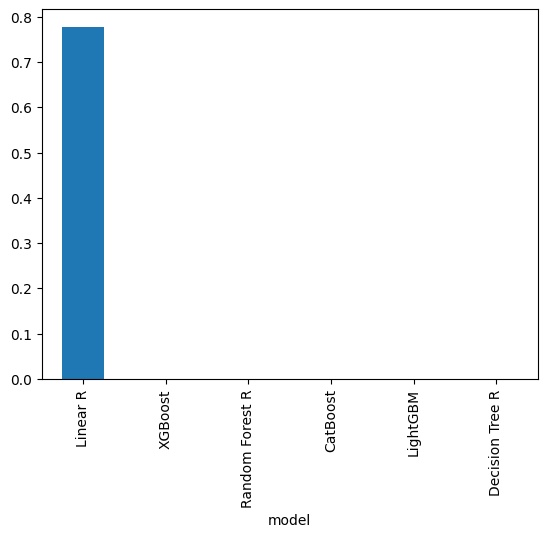

In [62]:
resumen_models['time_fit'].sort_values(ascending=False).plot(kind='bar')
plt.show()

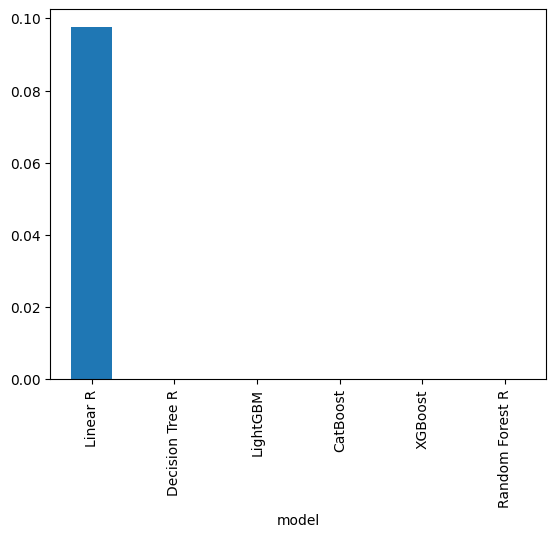

In [63]:
resumen_models['time_prediction'].sort_values(ascending=False).plot(kind='bar')
plt.show()

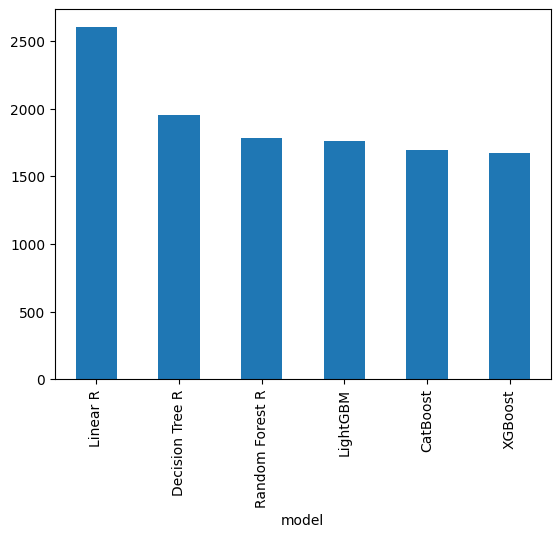

In [64]:
resumen_models['RMSE'].sort_values(ascending=False).plot(kind='bar')
plt.show()

Se observa que el modelo de Regresión lineal tiene el mayor tiempo de entrenamiento, predicción y valor de RMSE.

## Conclusión

1. El modelo de LightGBM, CatBoost y RandomForest presentan el menor tiempo de entrenamiento, seguido por XGBoost, Árbol de decisión y el mas largo fue la Regresión lineal con 0.77s. 

2. En cuanto al tiempo de predicción, el más largo fue el de Regresión lineal con 0.097s, este último modelo presenta su utilidad para realizar prueba de cordura; mientras que el de menor tiempo lo obtuvieron LightGBM, CatBoost, XGBoost y RandomForest.

3. El valor de RMSE fue menor para el modelo de XGBoost con 1674.07, seguido por CatBoost con 1694.73, LightGBM con 1761.57 y  Random Forest con 1783.08. 

4. En cuanto al tiempo que demoró para encontrar los parámetros adecuados utilizando *GridSearchCV* el mayor fue del modelo XGBoost; y de menor tiempo LightGBM.